### Multiplane Holography

The previous `slmsuite` examples have examined holography powered by discrete Fourier transforms (DFTs)
and by "compressed" Zernike kernels. We now examine a sort of meta holography
which "bakes" many simple objectives into a single hologram. These objectives can span 
planes of focus (DFTs or spots at different $z$ positions), 
planes of color (DFT grids or kernels scaled for different wavelengths), 
planes of basis (combining DTF and kernel objectives into the same hologram), 
or more!


#### Initialization

To start, we initialize our system:

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

In [2]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can skip the next cell.
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1600, 1200), pitch_um=(8,8))
slm.set_source_analytic(sim=True)               # Program the virtual source.
slm.set_source_analytic()                       # Don't bother with wavefront calibration, instead just set it to the same source.

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", fliplr=True)
fs = FourierSLM(cam, slm)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn '02C5V' initializing... success


smooth:   0%|          | 0/16 [00:00<?, ?it/s]

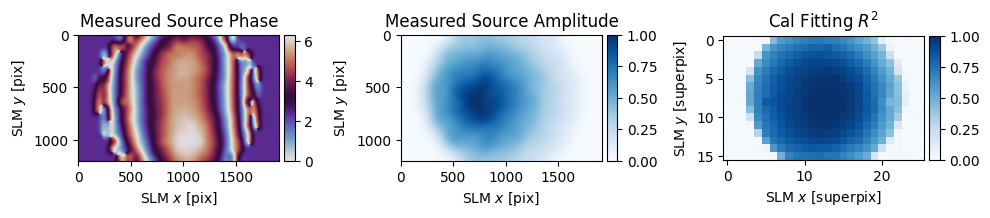

In [4]:
fs.read_calibration("wavefront_superpixel")
fs.wavefront_calibration_superpixel_process(r2_threshold=.5, plot=True);

In [5]:
fs.fourier_calibrate(40, 20, plot=True)

  0%|          | 0/10 [00:00<?, ?it/s]

{'M': array([[28832.50706272, -1175.63766493],
        [ 1180.75185038, 28846.10635605]]),
 'b': array([[722.809654 ],
        [527.3320239]]),
 'a': array([[-1.13039625e-19],
        [ 0.00000000e+00]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-25 22:13:44.377169',
 '__timestamp__': 1721960024.377169,
 '__meta__': {'camera': '02C5V', 'slm': '2018021001'}}

We make a function to help with building our banner image.

In [6]:
# Helper function for setting up banner sizes and MRAF on images.
path = os.path.join(os.getcwd(), '../../slmsuite/docs/source/static/slmsuite-small.png')

from slmsuite.holography.analysis.files import _read_image
from slmsuite.holography.toolbox.phase import lens

h, w = banner_shape = (640, 1280)
x, y = banner_shift = (0, -215)

y0, x0 = np.array(cam.shape) / 2

x += x0
y += y0

i0,i1,i2,i3 = (int(y-h/2), int(y+h/2), int(x-w/2), int(x+w/2))

def load_img(path):
    target_ij = _read_image(path, cam.shape, shift=(-225, -170))

    # Fill with nan for MRAF outside the bounds of the banner.
    p = 5

    target_ij[:(i0-p), :] = np.nan
    target_ij[(i1+p):, :] = np.nan
    target_ij[:, :(i2-p)] = np.nan
    target_ij[:, (i3+p):] = np.nan

    return target_ij

#### Planes of Focus

Optimizing a hologram at a detuned $z$ position is as simple as adding a given `propogation_kernel`
to the DFT which maps the nearfield of the SLM to the farfield. Instead of being located at exactly the depth of focus of the
system, the DFT grid will instead follow the detuned focus (and aberration) of the `propogation_kernel`.
We can make a series of holograms (comprising the three parts of our logo) at different depths.
Here, the depth is determined by the `lens(f)` phase function, which adds a lens with focal length $f$
to our system at the plane of the SLM. The case of $f=\infty$ corresponds to no lens.

In [7]:
from slmsuite.holography.algorithms import FeedbackHologram

f_eff_target = 1e7
targets = []
kernels = []
holograms = []
weights = []

# Gather three objectives for a fancy slmsuite logo.
for sym, f_eff in zip(["smith", "spin", "text"], [-f_eff_target, np.inf, f_eff_target]):
    target_ij = load_img(os.path.join(os.getcwd(), f'../../slmsuite/docs/source/static/slmsuite-small-{sym}.png'))
    kernel = lens(slm, f_eff)

    targets.append(target_ij)
    kernels.append(kernel)
    holograms.append(
        FeedbackHologram(
            (2048, 2048),
            target_ij,
            null_region_radius_frac=.5,                 # Helper function for MRAF.
            cameraslm=fs,
            propagation_kernel=lens(slm, f_eff)         # We're setting different planes of focus here with an appropriate lens().
        )
    )
    weights.append(np.sqrt(np.nansum(np.square(target_ij.astype(float)))))

This is what we loaded: three parts of a now-3D image with the encoded desired depths.

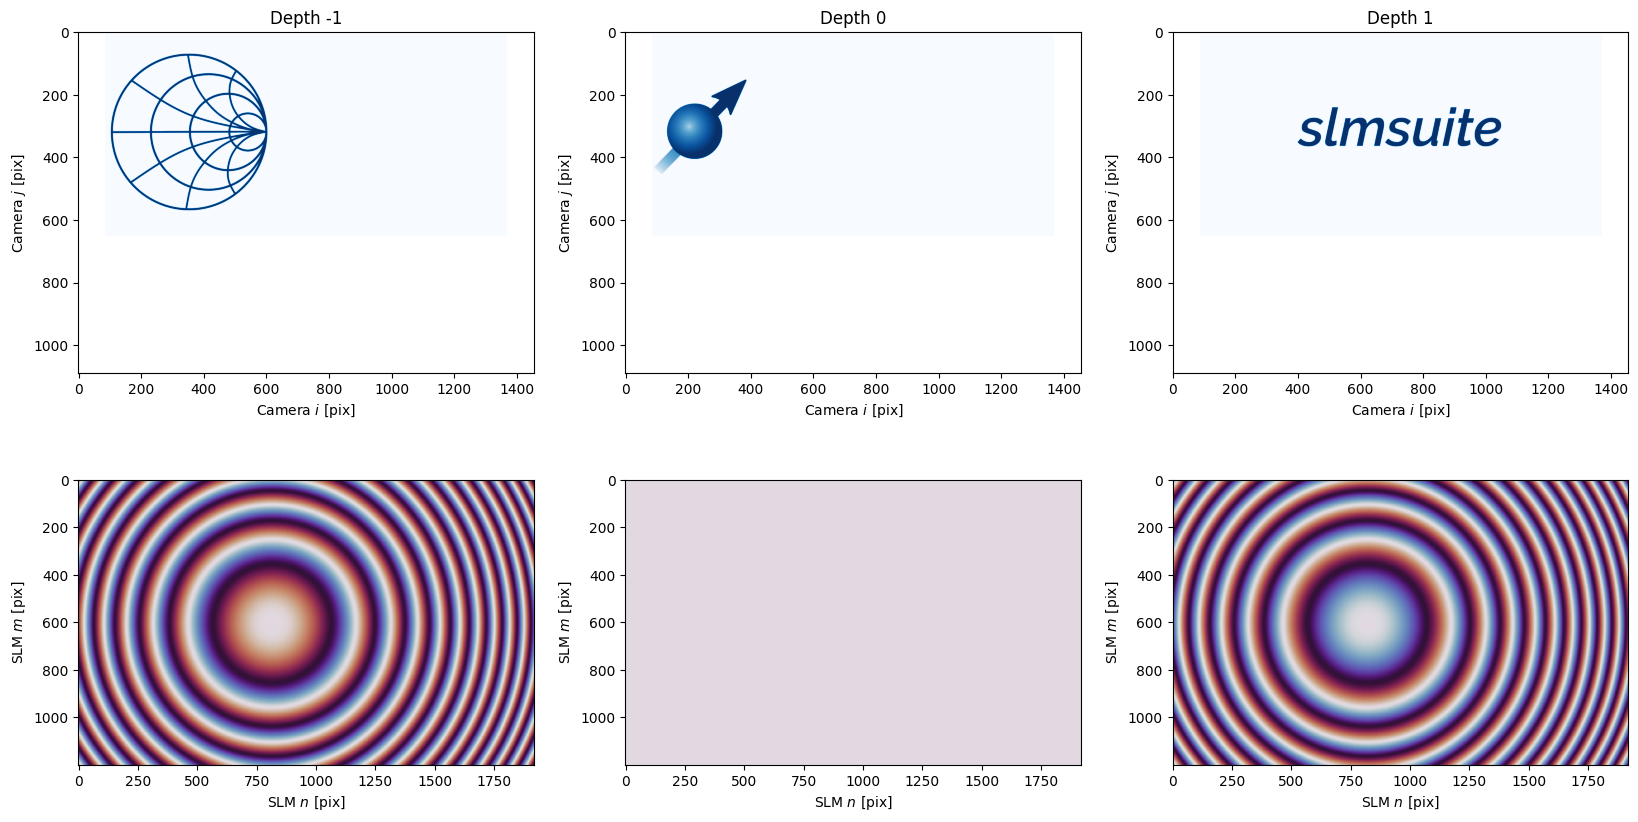

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20,10)); axs=axs.ravel()

for i, target, kernel in zip(range(3), targets, kernels):
    cam.plot(target, title=f"Depth {i-1}", ax=axs[i], cbar=False)
    slm.plot(kernel, title="", ax=axs[3+i], cbar=False)

We can now make a meta-hologram out of these `FeedbackHologram` objectives.
The `weights` factors encodes the relative weight of each objective,
as the intensity of the image is lost when each is normalized upon `FeedbackHologram` initialization.

In [9]:
from slmsuite.holography.algorithms import MultiplaneHologram

mh = MultiplaneHologram(holograms=holograms, weights=weights)

Next, we optimize. Here, we initialize with a quadratic phase guess and apply MRAF to reduce speckle.

In [10]:
mh.reset_phase(random_phase=0, quadratic_phase=2)
mh.optimize(method="GS", maxiter=5, mraf_factor=1)
mh.optimize(method="WGS-Leonardo", maxiter=20, mraf_factor=.5, feedback="computational")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

We can take a first look at our result by looking at the computational farfield.
This calls `.plot_farfield()` for each of the child holograms, and each farfield
is examined with the desired propagation kernel applied. It is this farfield
which is optimized against.

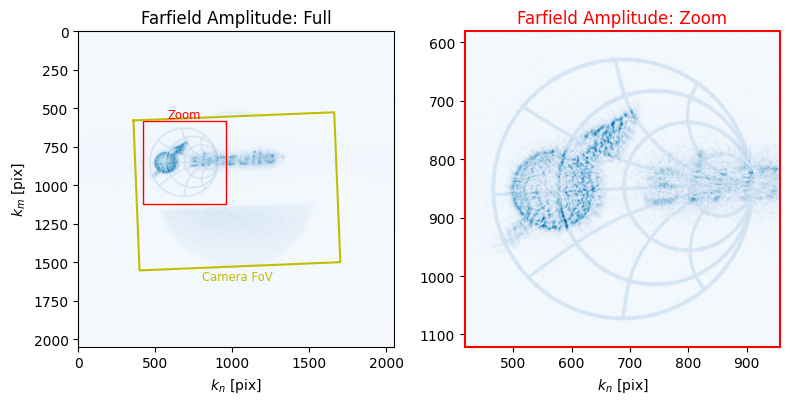

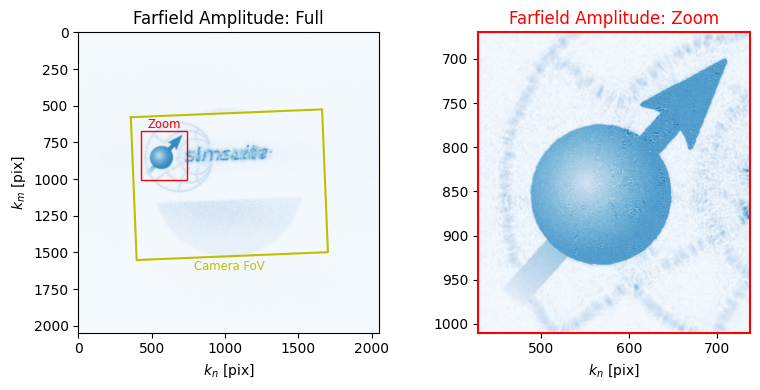

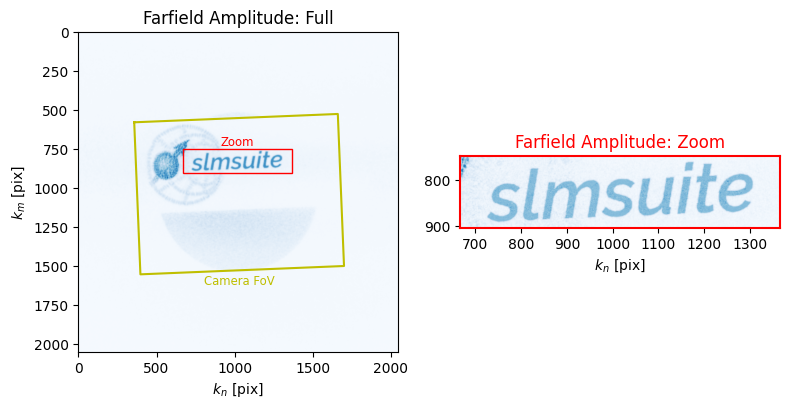

In [11]:
mh.plot_farfield()

But we can do more than this. Image feedback works the same way for multiplane holograms,
except this time the `propagation_kernel` is used to focus the spot for each experimental feedback image.
This takes a bit longer because we settle three times and capture three images (one for each plane)
during each iteration.

In [12]:
cam.set_exposure(.25)
mh.optimize(method="WGS-tanh", maxiter=10, mraf_factor=.5, feedback_factor=.5, feedback_exponent=10, feedback="experimental")

  0%|          | 0/10 [00:00<?, ?it/s]

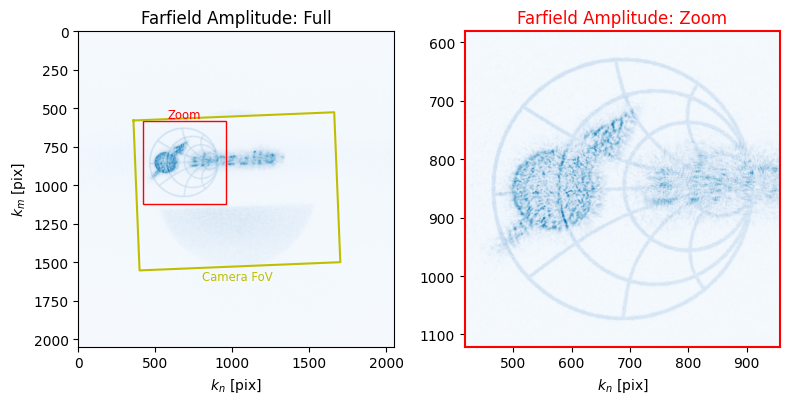

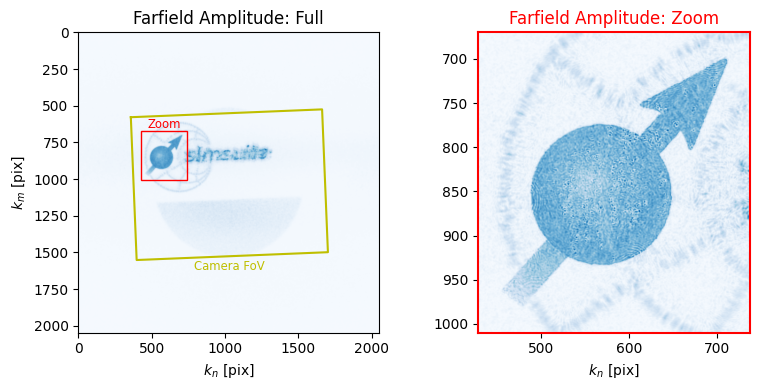

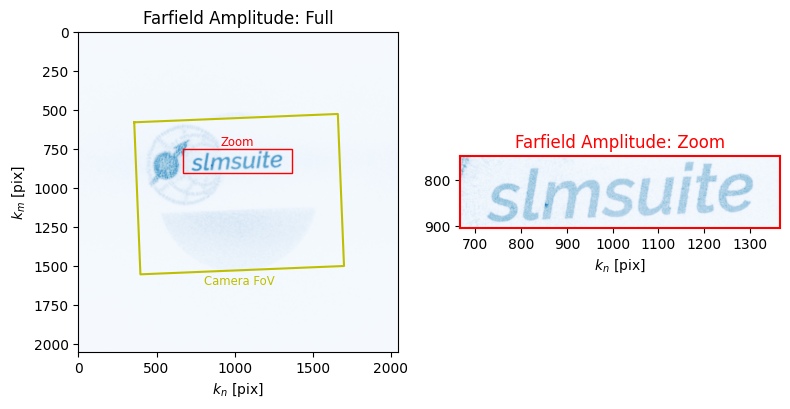

In [13]:
mh.plot_farfield()

Now let's take a look at the final result.

In [14]:
import tqdm.auto as tqdm

osc = (1/f_eff_target) * np.sin(np.linspace(0, 2*np.pi, 25))
cam.set_exposure(.25)

imgs = []

for f in tqdm.tqdm(np.reciprocal(osc)):
    slm.write(mh.get_phase() + lens(slm, f))
    cam.flush()
    img_ij = cam.get_image()

    banner = img_ij[i0:i1, i2:i3]
    imgs.append(banner)

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
from slmsuite.holography.analysis.files import write_image

imgs2 = np.copy(imgs)
imgs2[imgs2 > 127] = 127
imgs2 *= 2

write_image("ex-mutiplane.gif", imgs2, cmap="Blues", normalize=False)
write_image("ex-mutiplane-dark.gif", imgs, cmap="turbo", normalize=False)

![light](ex-mutiplane.gif) 
![dark](ex-mutiplane-dark.gif)

#### Planes of Basis

Alongside meta objectives consisting of many DFT holograms at different planes of focus,
we can combine DFT- and kernel/spot- based objectives in the same hologram.
This image is used for the `slmsuite` banner image on GitHub.
We first again load our image, this time in a single plane because in the end
we will want to have a static image instead of a .gif.

In [16]:
from slmsuite.holography.algorithms import FeedbackHologram

holograms = []
weights = []

# Load the image.
target_ij = load_img(os.path.join(os.getcwd(), f'../../slmsuite/docs/source/static/slmsuite-small.png'))

holograms.append(
    FeedbackHologram(
        (2048, 2048),
        target_ij,
        null_region_radius_frac=.5,
        cameraslm=fs
    )
)

For the spots, we want to make two Zernike pyramids. One is the usual that we made in a previous example.
The other makes use of a secret less-documented Zernike index `-1`. This is nonsensical as an ANSI Zernike
index, but in `slmsuite` it is the keyword for a $LG_{pl} = LG_{01}$ polynomial or vortex waveplate which produces
a bottle beam in the farfield. In the future, we might support more special keywords in the negative integers.

In [17]:
from slmsuite.holography.algorithms import CompressedSpotHologram
from slmsuite.holography.toolbox import convert_vector
from slmsuite.holography.toolbox.phase import zernike_convert_index

# Make two pyramids of order 7 in the camera basis.
N = 28
i = np.arange(N)
nl = zernike_convert_index(i, from_index="ansi", to_index="radial")
p = 27
x = 1175
y = cam.shape[0]/2 + banner_shift[1]

vectors_ij = np.hstack((
    np.vstack((x + p * nl[:, 1], y - p * (1 + nl[:, 0] * np.sqrt(3)))),
    np.vstack((x + p * nl[:, 1], y + p * (1 + nl[:, 0] * np.sqrt(3))))
))

# Then convert to the Zernike basis and add a pertubation.
vectors_zernike_xy = convert_vector(
    vectors_ij,
    from_units="ij",
    to_units="zernike",
    hardware=fs
)

vectors_zernike = np.zeros((N,2*N))
vectors_zernike[2, :] = vectors_zernike_xy[0]
vectors_zernike[1, :] = vectors_zernike_xy[1]

perturbation = np.diag(np.ones(N))
perturbation = np.hstack((perturbation, perturbation))

vectors_zernike_pyramid = vectors_zernike + 10*perturbation

# Give the upper pyramid a LG03 term.
vectors_zernike_final = np.vstack((vectors_zernike_pyramid, np.zeros(2*N)))
vectors_zernike_final[-1, :N] = 3 # LG03
basis = np.hstack((i, [-1]))

holograms.append(
    CompressedSpotHologram(
        spot_vectors=vectors_zernike_final,
        basis=basis,
        cameraslm=fs
    )
)

Finally, we make and optimize the meta-hologram. Here, the weights are less balanced than the previous example,
but that's expected because the Zernike pyramids need comparatively smaller power.

In [18]:
from slmsuite.holography.algorithms import MultiplaneHologram

mh = MultiplaneHologram(holograms=holograms, weights=[1, .0003])

mh.reset_phase(random_phase=0, quadratic_phase=2)
mh.optimize(method="WGS-Leonardo", maxiter=10, mraf_factor=1, feedback_exponent=.8, feedback="computational")

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
cam.set_exposure(.25)
mh.optimize(method="WGS-tanh", maxiter=40, mraf_factor=.5, feedback_factor=.5, feedback_exponent=5, feedback="experimental")

  0%|          | 0/40 [00:00<?, ?it/s]

Now let's collect the banner!

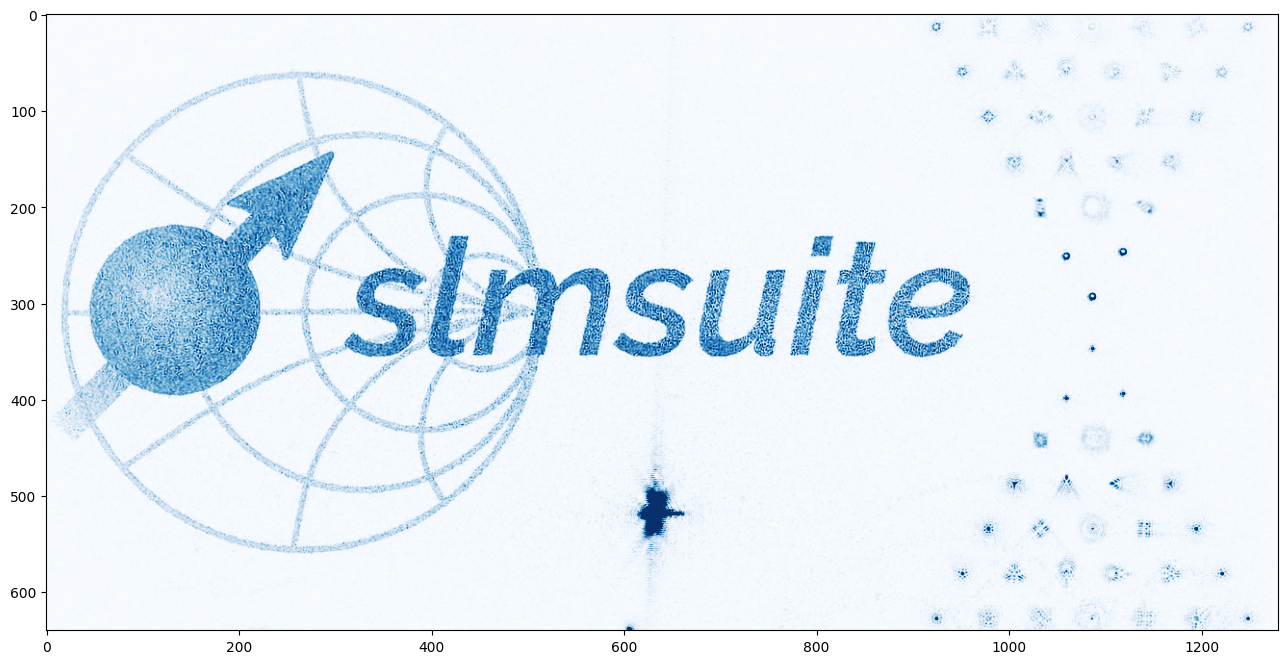

In [20]:
slm.write(mh.get_phase())
cam.set_exposure(.6)
img_ij = cam.get_image()

banner = img_ij[i0:i1, i2:i3]

plt.figure(figsize=(16,8))
plt.imshow(banner)
plt.show()

write_image("dynamic/slmsuite-banner.png", banner, cmap=True, border=127)

#### Planes of Both

As a final example hologram, let's combine the two previous cases.
We want to make the 3D `slmsuite` logo moving through a starfield of bottle beams.

In [21]:
from slmsuite.holography.algorithms import FeedbackHologram

f_eff_target = 1e7
targets = []
kernels = []
holograms = []
weights = []

# Gather three objectives for a fancy slmsuite logo.
for sym, f_eff in zip(["smith", "spin", "text"], [-f_eff_target, np.inf, f_eff_target]):
    target_ij = load_img(os.path.join(os.getcwd(), f'../../slmsuite/docs/source/static/slmsuite-small-{sym}.png'))
    kernel = lens(slm, f_eff)

    targets.append(target_ij)
    kernels.append(kernel)
    holograms.append(
        FeedbackHologram(
            (2048, 2048),
            target_ij,
            null_region_radius_frac=.5,                 # Helper function for MRAF.
            cameraslm=fs,
            propagation_kernel=lens(slm, f_eff)         # We're setting different planes of focus here with an appropriate lens().
        )
    )

    weights.append(np.sqrt(np.nansum(np.square(target_ij.astype(float)))))

Now we move onto the bottle beams. We use the same ANSI index `-1` as before to add a
vortex waveplate term to the Zernike basis.
For clarity, we also tell the spots to avoid the DFT holograms via blurring and each other via `lloyds_algorithm()`.

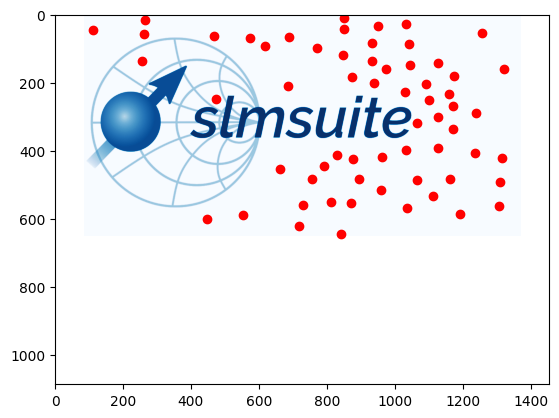

In [22]:
from slmsuite.holography.algorithms import CompressedSpotHologram
import cv2

# Make the starfield
# Points
N_spots = 100

spots_ij = np.vstack((
    np.random.randint(i2, i3, size=N_spots),
    np.random.randint(i0, i1, size=N_spots)
))

from slmsuite.holography.toolbox import lloyds_algorithm
from slmsuite.holography.analysis import _generate_grid

spots_ij = lloyds_algorithm(
    _generate_grid(cam.shape[1], cam.shape[0]),
    spots_ij,
    iterations=1
).astype(int)

# Remove points which are close of the logo.
target_ij = load_img(
    os.path.join(os.getcwd(), f'../../slmsuite/docs/source/static/slmsuite-small.png')
)

target_ij_blur = cv2.GaussianBlur(target_ij.astype(np.uint8), (61,61), 0)

nooverlap = np.logical_and(
    target_ij_blur[spots_ij[1], spots_ij[0]] == 0,
    np.logical_not(np.isnan(target_ij[spots_ij[1], spots_ij[0]]))
)
spots_ij = spots_ij[:, nooverlap]
N_spots = spots_ij.shape[1]

plt.imshow(target_ij)
plt.scatter(spots_ij[0], spots_ij[1], c="r")
plt.show()

# Convert to kxy units so we can add on depth in units of focal power.
spots_kxy = convert_vector(
    spots_ij,
    from_units="ij",
    to_units="kxy",
    hardware=fs
)

spots_kxyz = np.vstack((
    spots_kxy,
    2 * (np.random.rand(N_spots) - .5) / f_eff_target
))

# Finally, convert to zernike.
spots_zernike = convert_vector(
    spots_kxyz,
    from_units="kxy",
    to_units="zernike",
    hardware=fs
)

# Turn every spot into a bottle beam.
basis = [
    2,      # x
    1,      # y
    4,      # z
    -1      # LG10 - vortex waveplate
]

spots_zernike = np.vstack((
    spots_zernike,
    2 * np.ones((1, N_spots))   # LG20 on every spot, for fun.
))

# Make the spot hologram.
holograms.append(
    CompressedSpotHologram(
        spot_vectors=spots_zernike,
        basis=basis,
        cameraslm=fs
    )
)
weights.append(.5)

Making the hologram, optimizing, and monitoring the result is as simple as before:

In [23]:
from slmsuite.holography.algorithms import MultiplaneHologram

mh = MultiplaneHologram(holograms=holograms, weights=weights)

mh.reset_phase(random_phase=0, quadratic_phase=2)
mh.optimize(method="GS", maxiter=5, mraf_factor=1)
mh.optimize(method="WGS-Leonardo", maxiter=20, mraf_factor=1, feedback="computational")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

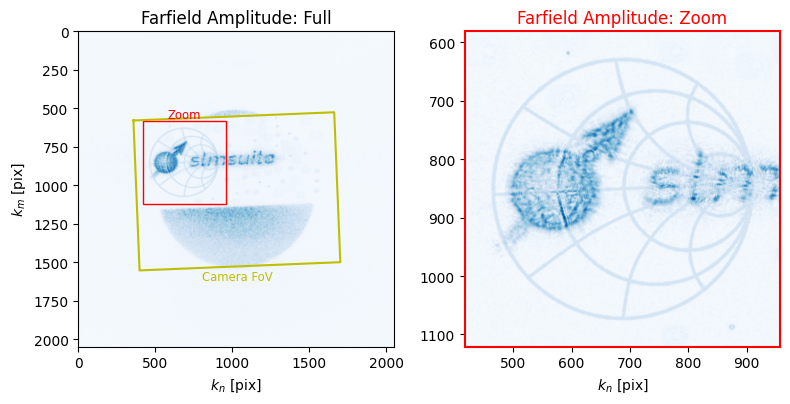

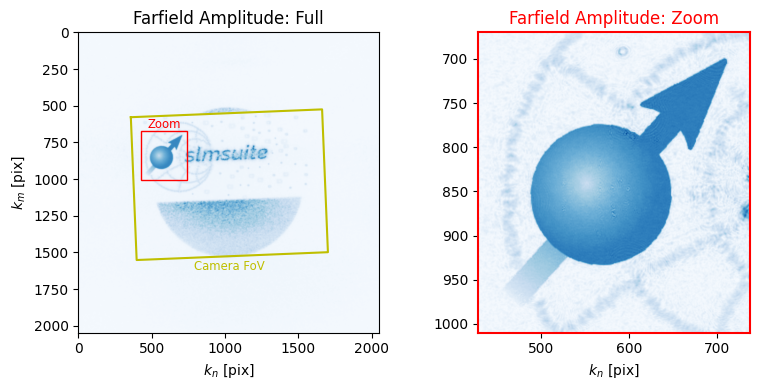

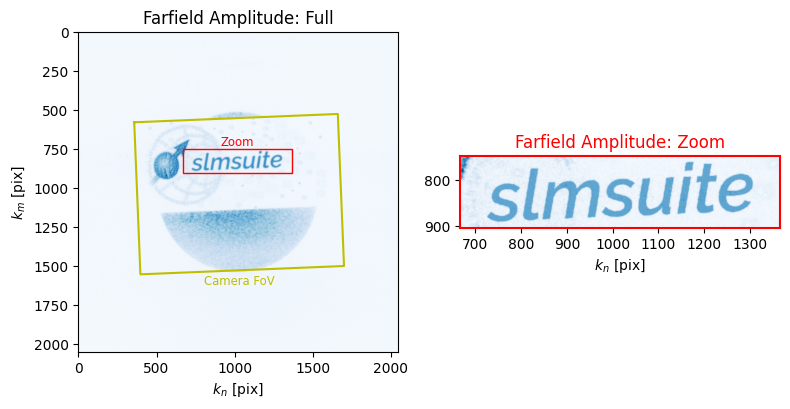

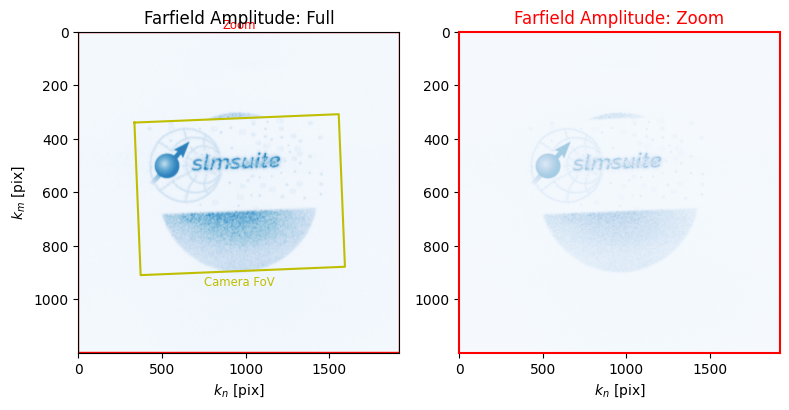

In [24]:
mh.plot_farfield()

In [25]:
cam.set_exposure(.25)
mh.optimize(method="WGS-tanh", maxiter=20, mraf_factor=.5, feedback_factor=.5, feedback_exponent=5, feedback="experimental")

  0%|          | 0/20 [00:00<?, ?it/s]

We again collect the spots, oscillating in $z$.

In [26]:
import tqdm.auto as tqdm

osc = (1/f_eff_target) * np.sin(np.linspace(0, 2*np.pi, 25))
cam.set_exposure(.6)

imgs = []

for f in tqdm.tqdm(np.reciprocal(osc)):
    slm.write(mh.get_phase() + lens(slm, f))
    cam.flush()
    img_ij = cam.get_image()

    banner = img_ij[i0:i1, i2:i3]
    imgs.append(banner)

  0%|          | 0/25 [00:00<?, ?it/s]

In [27]:
from slmsuite.holography.analysis.files import write_image

# The .gifs are a bit large at raw resolution for GitHub unfortunately, so we downscale by 2x
N = 2
imgs = np.array(imgs)
imgs2 = 0

for x in range(N):
    for y in range(N):
        imgs2 += imgs[:, x::N, y::N] // (N * N)

write_image("ex-slmsuite-3d.gif", imgs2, cmap="Blues", border=127, normalize=False)
write_image("ex-slmsuite-3d-dark.gif", imgs2, cmap="turbo", border=127, normalize=False)

![light](ex-slmsuite-3d.gif) 
![dark](ex-slmsuite-3d-dark.gif)

#### Afterword

Altogether, `MultiplaneHologram` enhances the versatility of holography with `slmsuite`
Wherever the user is interested in the state of the farfield, at whichever focus or color,
the user can wrest control in the form of DFT grids or spots in aberration-space.

We look forward to seeing the novel combinations of objectives you will create!